In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime
import openpyxl
matplotlib.pyplot.close()

## Import Data from CSV
Data comes in as a CSV file. Make python just... turn it into a dataframe for me.
26.3MB

### Convert Data formats

Useful functions: 
* .dt.at_time()
* .dt.between_time(): DataFrame.between_time(start_time, end_time, inclusive='both', axis=None)[source]
    * Select values between particular times of the day (e.g., 9:00-9:30 AM).
    * By setting start_time to be later than end_time, you can get the times that are not between the two times.

In [3]:
df = pd.read_csv("chicago.csv", parse_dates=["Start Time","End Time"],index_col=0)
#df["Rental Period"] = pd.to_period()
df['User Type'] = df['User Type'].astype("category")
df["Duration"] = pd.to_timedelta(df["Trip Duration"],'sec')
df["Birth Year"] = df["Birth Year"].fillna(0).astype(int)
df.drop(columns=["Trip Duration"],inplace=True)
df["Month"] = df["Start Time"].dt.month_name()
df["Day"] = df["Start Time"].dt.date
df["ETime"] = [x.replace(year=1970, month=1, day = 1) for x in pd.to_datetime(df["Start Time"],format)] #.replace(year=2017, month=1, day = 1)
df.info()

df.sort_values(by=['ETime'], inplace=True)
#df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 1423854 to 1021247
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   Start Time     300000 non-null  datetime64[ns] 
 1   End Time       300000 non-null  datetime64[ns] 
 2   Start Station  300000 non-null  object         
 3   End Station    300000 non-null  object         
 4   User Type      300000 non-null  category       
 5   Gender         238948 non-null  object         
 6   Birth Year     300000 non-null  int32          
 7   Duration       300000 non-null  timedelta64[ns]
 8   Month          300000 non-null  object         
 9   Day            300000 non-null  object         
 10  ETime          300000 non-null  datetime64[ns] 
dtypes: category(1), datetime64[ns](3), int32(1), object(5), timedelta64[ns](1)
memory usage: 24.3+ MB


## Exploration

In [310]:
df.value_counts(subset=['User Type','Gender'])

User Type   Gender
Subscriber  Male      181107
            Female     57749
Customer    Male          82
            Female         9
Dependent   Male           1
dtype: int64

                      ETime        Duration
1433491 1970-01-01 00:00:00 0 days 00:16:08
865090  1970-01-01 00:00:00 0 days 00:09:43
1271868 1970-01-01 00:00:01 0 days 00:04:54
1202508 1970-01-01 00:00:02 0 days 00:46:37
1081023 1970-01-01 00:00:02 0 days 01:13:34
...                     ...             ...
600685  1970-01-01 23:59:57 0 days 00:02:06
1283140 1970-01-01 23:59:58 0 days 00:25:32
879384  1970-01-01 23:59:58 0 days 00:02:24
1416663 1970-01-01 23:59:59 0 days 00:07:38
899821  1970-01-01 23:59:59 0 days 00:09:43

[300000 rows x 2 columns]


array([[<Axes: title={'center': 'Duration'}>]], dtype=object)

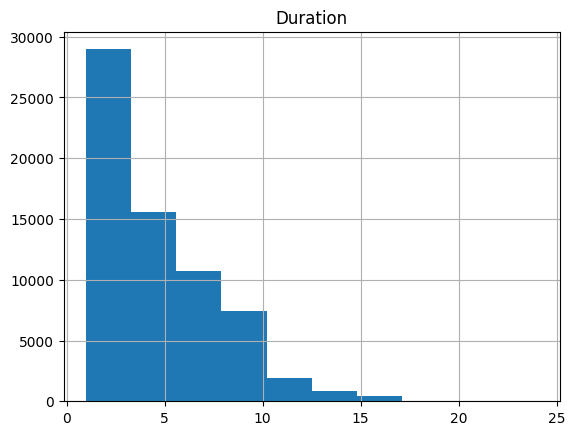

In [246]:
df2 = df.take([10,7],'columns')
print(df2)
df3 = df2.groupby(["ETime"]).count()
df3.hist()

## Steps to transform chamber data

1. Shift on status column to get a subtable of all times where the status changed
2. Grab the range of time in a purge as "less than next status time"
3. Remove irrelevant or unwanted statuses (keep "purge", "ready")
4. Remaining purge-to-purge slices are now initial set of test points
5. Join on test points to summarize various statistics of other fields 

In [4]:
alternating_status = df.take([10,4],'columns') # 10=Time, 7=Duration, 4=UserType
alternating_status = alternating_status[alternating_status["User Type"].shift() != alternating_status["User Type"]]
alternating_status["End"] = alternating_status["ETime"].shift(-1,fill_value=pd.Timestamp(year=1970,month=1,day=1,hour=23,minute=59,second=59,microsecond=999999))

alt_stat = alternating_status[alternating_status["User Type"]=='Subscriber'].copy().drop(columns='User Type').reset_index(drop=True)
alt_stat

,ETime,End
0,1970-01-01 00:00:00,1970-01-01 00:00:02.000000
1,1970-01-01 00:00:03,1970-01-01 00:00:18.000000
2,1970-01-01 00:00:23,1970-01-01 00:00:43.000000
3,1970-01-01 00:00:45,1970-01-01 00:01:05.000000
4,1970-01-01 00:01:05,1970-01-01 00:01:12.000000
...,...,...
45275,1970-01-01 23:59:47,1970-01-01 23:59:49.000000
45276,1970-01-01 23:59:49,1970-01-01 23:59:51.000000
45277,1970-01-01 23:59:53,1970-01-01 23:59:55.000000
45278,1970-01-01 23:59:57,1970-01-01 23:59:58.000000


## Random Subset of Time Periods as Test Points

Only run when you need to generate a new body of test points!

This link shows methods on how to count values between times. 
https://stackoverflow.com/questions/45208387/pandas-count-rows-between-in-two-date-columns

In [301]:
as2 = alt_stat.sample(n=50).sort_values('ETime',axis='index')
as2 = as2.reset_index().rename(columns={'index':'tp_num'})

with pd.ExcelWriter('test_points.xlsx', mode='a') as writer:  
    as2.to_excel(writer, sheet_name='50 Test Points')


## Import Excel Sheet as Test Point Periods

In [4]:
as2 = pd.read_excel('test_points.xlsx',sheet_name='Custom Test Points')
as2

,tp_num,ETime,End
0,1,1970-01-01 00:26:09.000,1970-01-01 01:02:09.000
1,2,1970-01-01 02:02:37.800,1970-01-01 02:38:37.800
2,3,1970-01-01 03:39:06.600,1970-01-01 04:15:06.600
3,4,1970-01-01 05:15:35.400,1970-01-01 05:51:35.400
4,5,1970-01-01 06:52:04.200,1970-01-01 07:28:04.200
5,6,1970-01-01 08:28:33.000,1970-01-01 09:04:33.000
6,7,1970-01-01 10:05:01.800,1970-01-01 10:41:01.800
7,8,1970-01-01 11:41:30.600,1970-01-01 12:17:30.600
8,9,1970-01-01 13:17:59.400,1970-01-01 13:53:59.400
9,10,1970-01-01 14:54:28.200,1970-01-01 15:30:28.200


## Label rows from the original table that fall between the times in a test point with that point's label

In [14]:
#df.insert(len(df.columns),'minmatchtime',0)
#df.head()
start2 = datetime.now()
tp_df = df.head(1).copy().drop(1433491).reset_index().set_index('ETime')
for tp in as2.itertuples():
    ndf = df.reset_index().set_index('ETime').between_time(tp[2].time(),tp[3].time(),inclusive='both', axis='index')
    ndf['tp_num'] = tp[1]
    tp_df = pd.concat([tp_df,ndf])

end2 = datetime.now()
print('This loop ran in ',(end2-start2))
#print(tp_df)
new = tp_df.reset_index().set_index('index')
df=df.join(new.take([11],axis=1),how='left', rsuffix='_tp')
df.info()

#df3 = df.take(['10']).compare(alt_stat.take(['1']),keep_equal=True)
#df3 = pd.merge_asof(df, alt_stat, on="ETime", direction='backward')
#df3

This loop ran in  0:00:01.867007
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 1433491 to 899821
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   Start Time     300000 non-null  datetime64[ns] 
 1   End Time       300000 non-null  datetime64[ns] 
 2   Start Station  300000 non-null  object         
 3   End Station    300000 non-null  object         
 4   User Type      300000 non-null  category       
 5   Gender         238948 non-null  object         
 6   Birth Year     300000 non-null  int32          
 7   Duration       300000 non-null  timedelta64[ns]
 8   Month          300000 non-null  object         
 9   Day            300000 non-null  object         
 10  ETime          300000 non-null  datetime64[ns] 
 11  tp_num         112198 non-null  float64        
 12  tp_num_tp      112198 non-null  float64        
dtypes: category(1), datetime64[ns](3), float64(2), int

In [15]:
df.nunique()

Start Time       292758
End Time         291109
Start Station       568
End Station         572
User Type             3
Gender                2
Birth Year           80
Duration           7157
Month                 6
Day                 181
ETime             65880
tp_num               15
tp_num_tp            15
dtype: int64

array([[<Axes: xlabel='tp_num', ylabel='Avg Duration'>,
        <Axes: xlabel='tp_num', ylabel='Avg Duration'>]], dtype=object)

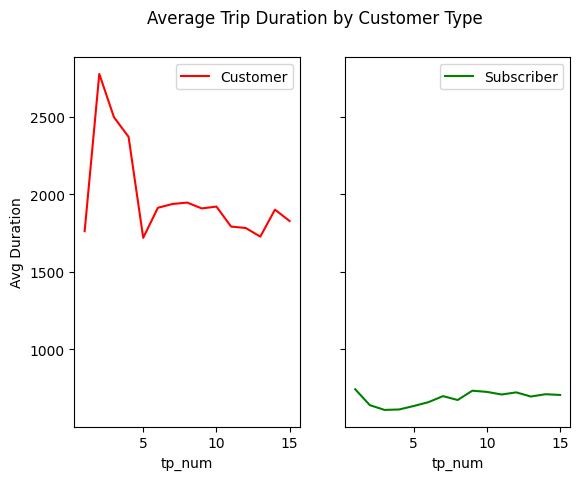

In [16]:
#df_agg = df.agg
df_math = df.reset_index().dropna(subset=['tp_num']).set_index(['tp_num','User Type'])
df_plot = df_math['Duration'].groupby(level=['tp_num','User Type']).mean().dt.total_seconds()
df_plot = df_plot.unstack()
#df_plot['colors'] = df_plot['User Type'].cat.rename_categories(1,2)
df_plot.reset_index('tp_num').plot.line(x='tp_num',ylabel='Avg Duration',subplots=True,layout=(1,2),title='Average Trip Duration by Customer Type',sharey=True,color={'Customer':'red','Subscriber':'green'})

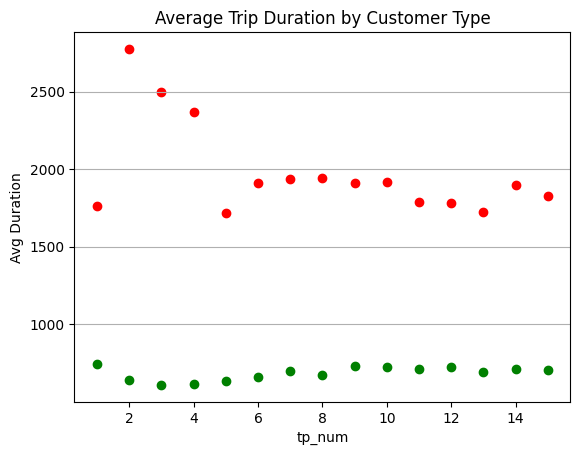

User Type     Customer  Subscriber
tp_num                            
1.0        1761.139037  742.482003
2.0        2774.760000  640.282759
3.0        2496.282051  609.451220
4.0        2369.133333  612.283610
5.0        1718.465347  634.650396
6.0        1912.083439  659.335474
7.0        1936.579249  698.373996
8.0        1945.667214  673.396087
9.0        1907.957727  733.315487
10.0       1919.856045  725.671636
11.0       1791.105659  708.895818
12.0       1781.862986  722.419299
13.0       1726.311628  695.736286
14.0       1900.247074  710.609975
15.0       1826.645880  706.037700


<Figure size 640x480 with 0 Axes>

In [10]:
fig, ax = plt.subplots()
ax.set(title = 'Average Trip Duration by Customer Type',
       xlabel = 'tp_num',
       ylabel = 'Avg Duration')
ax.yaxis.grid()
ax.scatter(df_plot.index,df_plot.iloc[:,0],color='r')
ax.scatter(df_plot.index,df_plot.iloc[:,1],color='g')
plt.show()
print(df_plot)
plt.savefig('outputs/python_pretty_plot.png')

## The End: Write all data to an excel sheet for user

https://www.geeksforgeeks.org/how-to-write-pandas-dataframes-to-multiple-excel-sheets/

In [20]:
with pd.ExcelWriter("outputs/outputs.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    as2.to_excel(writer, sheet_name="Test Point Periods")
    df.to_excel(writer, sheet_name="Labeled Data")
    df_plot.to_excel(writer, sheet_name="Durations", index=True)
    #data_frame2.to_excel(writer, sheet_name="Vegetables", index=False)
    #data_frame3.to_excel(writer, sheet_name="Baked Items", index=False)